In [1]:
### My Deep Learning Capstone

In [4]:
! pip install pydicom

     |████████████████████████████████| 35.3 MB 16.6 MB/s eta 0:00:01


In [1]:
# import all necessary libraries

import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt


from math import ceil, floor, log
import cv2
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import tensorflow as tf
import keras

import sys

from keras_applications.inception_v3 import InceptionV3

from sklearn.model_selection import ShuffleSplit
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [2]:
images_dir = 'images/'

In [2]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

In [3]:
def _read(path, desired_size):
    """Function to read data which will be used in the Data Generator class"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

In [4]:
def _normalized_weighted_average(arr, weights=None):
    """
    Keras implementation for numpy.average()
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Using this as the metric in model.compile
    Similar to weighted log loss but with normalized weights
    
    """
    
   
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

In [5]:
new_model = load_model('newmod (1).h5', custom_objects={'weighted_loss' : weighted_loss})

In [6]:
type(new_model)

keras.engine.training.Model

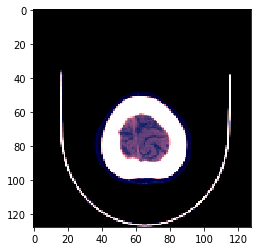

In [8]:
plt.imshow(
    _read('ID_9a8abe7ad'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

In [9]:
x = _read('ID_9a8abe7ad'+'.dcm', (256, 256))

In [10]:
x = new_model.predict(x.reshape(1, 256, 256, 3))

In [11]:
np.argmax(x)

0

In [27]:
from PIL import Image

UnidentifiedImageError: cannot identify image file 'images/ID_7a1c35755.dcm'